<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install joblib
import tensorflow as tf 
import pickle
#from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [148]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## 64 BIT (2253,4016)
'''
with open('/content/drive/My Drive/ffeatures64.bin','rb') as file:
  features = pickle.load(file)
with open('/content/drive/My Drive/flabels64.bin','rb') as file:
  labels = pickle.load(file)
'''

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 56 BIT (2253,3147)
'''
features = joblib.load('/content/features56.pkl')
labels = joblib.load('/content/labels56.pkl')
'''

In [0]:
## 64 BIT (2253,3147)

features = joblib.load('/content/features64.pkl')
labels = joblib.load('/content/labels64.pkl')


In [0]:
## 32 BIT (2253,1035)
'''
features = joblib.load('/content/features32.pkl')
labels = joblib.load('/content/labels32.pkl') '''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''

In [260]:
# print(features[0])
# print(len(features[0]))
# print(len(features))
print(np.shape(features))

(2253, 4107)


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [237]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12536811102307483961
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17810288432800085712
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2615115078038558223
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2963156849817122560
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
x = tf.placeholder(shape = (None,4107), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((4107, 8000)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,8000)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((8000,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


                

In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl = tf.add(tf.matmul(hidl,wo),bo,name = 'output')

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.3*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

In [270]:
train=[]
val=[]
with tf.device('/device:CPU:0'):
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,1000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
        
        ##TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      z= sess.run([loss,op_train], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      ##VALIDATION LOSS
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    
    simple_save(sess,'/content/drive/My Drive/Custom_Models/model1000_64upd',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    

3966.3726	63704.695
60015.477	5342.764
6335.1577	11260.829
10683.242	28945.834
29276.629	23000.715
23258.84	7151.609
6719.185	319.2499
842.1915	4296.136
3830.7588	9191.297
10597.449	10987.0
10623.154	6972.369
7047.7207	3249.7466
3394.8655	931.12213
1154.3668	312.71585
1212.2495	3417.5864
1740.7911	3480.3337
2974.5046	5937.237
2790.4824	4184.0806
3934.2747	3292.6836
3176.4663	1313.8755
4029.5522	564.24713
3197.63	672.79364
821.7951	817.046
513.4065	1010.92505
842.2469	1506.1221
1356.731	1768.1758
1919.609	2093.075
2147.1729	1875.6346
1504.3889	1031.9044
1804.861	681.639
1716.7244	1012.39087
533.41547	1216.0304
387.20975	812.88916
694.8766	1641.6744
2100.34	1120.725
435.34714	1809.3984
235.6984	440.67117
899.4183	1141.3113
1169.7869	1475.0063
475.7317	1251.3579
1883.4982	1601.2947
1721.8865	757.8828
1281.261	1097.3745
1319.9875	1100.8594
237.71707	751.7293
1203.7261	893.18005
1647.3125	998.5521
701.6621	619.5016
792.24866	913.04596
1196.3073	630.9941
1045.3319	930.10376
764.1895	925.0635

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64upd.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

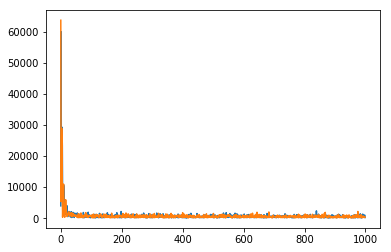

In [272]:
plt.plot(train)
plt.plot(val)

In [257]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(4107, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(500, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_updatedloss.pb', 'rb') as f:
  g1 = f.read()
with open('/content/drive/My Drive/Custom_Models/graph1000.pb', 'rb') as f:
  g2 = f.read()

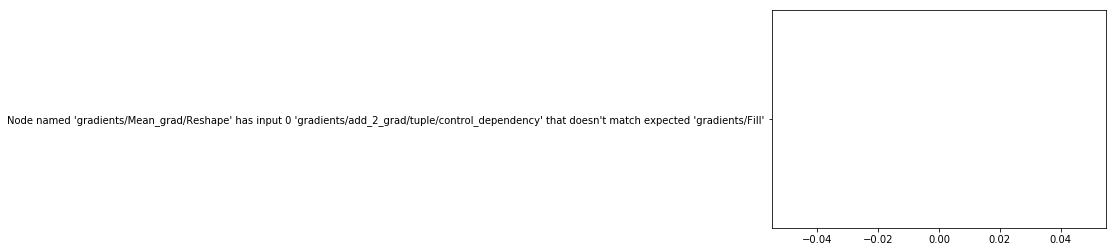

In [146]:
diff = pywrap_tensorflow.EqualGraphDefWrapper(g1,g2) 
#plt.plot(diff)